### First Juliet fit of WASP-17

Trying a joint fit with the first RV data I have in the DB (since it was already in BJD-TDB) and the two TESS light curves.

Initially copying the code from https://juliet.readthedocs.io/en/latest/tutorials/jointfits.html and editing to fit my data. 

Parameter values from https://exo.mast.stsci.edu/exomast_planet.html?planet=WASP17b (TESS-DV):

*Star*

Rs [R☉] 1.2 +0.081/-0.08

V mag 11.6

Ms [M☉] 1.19 ±0.03

K mag 10.2

[Fe/H] -0.25 ±0.09

RA [h:m:s] 15:59:50.947

log10(g) [cgs] 4.2 ±0.2

Dec [h:m:s] -28:03:42.30

Teff [K] 6550 ±100

Distance [pc] 400 ±60

Star Name WASP-17

TESS Mag 10.22

*Planetary System*

Rp [Rj] 1.932 +0.05/-0.1

Teq [K] 1546.58

Period [day] 3.735433 +7.5e-6/-7.7e-6

Transit Epoch [MJD] 54558.68096 +2.5e-4/-2.1e-4

Transit Duration [hour] 4.4232 +0.0312/-0.024

Depth [%] 1.672 +0.02/-0.016

Impact Parameter 0.4 ±0.04	

a/Rs 8.968 ±0.62

In [1]:
import juliet
import sqlite3 as sql
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pickle

/Users/rosteen/opt/anaconda3/envs/juliet/lib/python3.9/site-packages/autograd/numpy/numpy_wrapper.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  int_types = {_np.int, _np.int8, _np.int16, _np.int32, _np.int64, _np.integer}


In [6]:
# Define the master prior dictionary. First define the TRANSIT priors:
priors = {}

# Name of the parameters to be fit:
params = ['P_p1', 
          't0_p1', 
          'a_p1', 
          'b_p1',
          'p_p1',
          'q1_TESS', 
          'q2_TESS', 
          'ecc_p1', 
          'omega_p1',
          'rho', 
          'mdilution_TESS', 
          'mflux_TESS', 
          'sigma_w_TESS']

# Distribution for each of the parameters:
dists = ['normal','normal','normal','normal','normal','uniform',
         'uniform','fixed','fixed','loguniform', 'fixed', 'normal', 
         'loguniform']

# Hyperparameters of the distributions (mean and standard-deviation for normal
# distributions, lower and upper limits for uniform and loguniform distributions, and
# fixed values for fixed "distributions", which assume the parameter is fixed). Note prior
# on t0 has an added 2400000.5 to convert from MJD to JD:
hyperps = [[3.735433, 7.7e-6], 
           [2400000.5 + 54558.68096, 2.5e-4], 
           [8.968, 0.62], 
           [0.4, 0.04], 
           [1.2931, 0.011],
           [0., 1.], 
           [0., 1.], 
           0.0, 
           90., 
           [100., 10000.], 
           1.0, 
           [0.,0.1], 
           [0.1, 1000.]]

# Populate the priors dictionary:
for param, dist, hyperp in zip(params, dists, hyperps):
    priors[param] = {}
    priors[param]['distribution'], priors[param]['hyperparameters'] = dist, hyperp

# Now define the RV priors:
params = ['mu_MIKE', 
          'K_p1', 
          'sigma_w_MIKE']

# Distributions:
dists = ['uniform', 'uniform', 'uniform']

# Hyperparameters
hyperps = [[-100,100], [-100,100], [-100,100]]

# Populate the priors dictionary:
for param, dist, hyperp in zip(params, dists, hyperps):
    priors[param] = {}
    priors[param]['distribution'], priors[param]['hyperparameters'] = dist, hyperp

In [7]:
## Sometimes after running this cell once the fit errors, but if I run this again 
## it succeeds. Not sure why...

# Light curve data
times, fluxes, fluxes_error = {},{},{}
# RV data
times_rv, data_rv, errors_rv = {}, {}, {}

# Get data from DB and populate dictionaries
conn = sql.connect("shel_database.sqlite")
cur = conn.cursor()

# Tess light curves
res = cur.execute("select * from light_curves where target_id = 42").fetchall()
res = np.array(res)
t = res[:, 3]
f = res[:, 4]
f_err = res[:, 5]


times['TESS'], fluxes['TESS'], fluxes_error['TESS'] = t, f, f_err

# MIKE RV data
res = cur.execute("select * from radial_velocities where target_id = 42 and instrument = 5").fetchall()
res = np.array(res)

t = res[:,3]
rv = res[:,4]
rv_err = res[:,5]

times_rv['MIKE'], data_rv['MIKE'], errors_rv['MIKE'] = t, rv, rv_err

print(fluxes)
print(data_rv)

{'TESS': array([0.9957258701324463, 0.9982753396034241, 0.9994407892227173, ...,
       0.9994415044784546, 1.001538872718811, 0.9969558715820312],
      dtype=object)}
{'MIKE': array([-58.107, -32.591,   6.698,  -2.553,  77.061])}


In [8]:
# Load the dataset:
dataset = juliet.load(priors=priors, t_lc = times, y_lc = fluxes,
                      yerr_lc = fluxes_error, t_rv = times_rv, y_rv = data_rv,
                      yerr_rv = errors_rv, out_folder = 'WASP-17_jointfit')

# And now let's fit it!
#results = dataset.fit(n_live_points = 500)

In [9]:
results
with open("WASP-17_jointfit/results.pkl", "wb") as f:
    pickle.dump(results, f)

In [3]:
# Load from file if picking up here
with open("WASP-17_jointfit/results.pkl", "rb") as f:
    results = pickle.load(f)

In [15]:
%matplotlib inline
fig = plt.figure(figsize=(14,4))
gs = gridspec.GridSpec(1, 2, width_ratios=[2,2])

<Figure size 1008x288 with 0 Axes>

(0.96, 1.01)

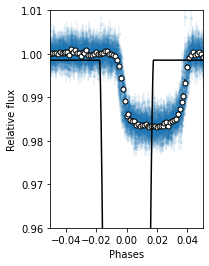

In [16]:
# Plot phased transit data and model first. Let's extract the transit
# model --- lightcurve is well sampled, so use the same input times to plot the model:
transit_model = results.lc.evaluate('TESS')

# Extract period and time-of-transit center for the planet:
P, t0 = np.median(results.posteriors['posterior_samples']['P_p1']),\
        np.median(results.posteriors['posterior_samples']['t0_p1'])

# Define plot, get phases, plot data and best-fit model:
ax1 = plt.subplot(gs[0])

phases = juliet.get_phases(dataset.times_lc['TESS'], P, t0)
idx = np.argsort(phases)
ax1.errorbar(phases, dataset.data_lc['TESS'], yerr= dataset.errors_lc['TESS'], fmt = '.', alpha=0.1)
ax1.plot(phases[idx],transit_model[idx], color='black',zorder=10)

# Plot binned data as well, binning 40 datapoints in phase-space:
p_bin, y_bin, yerr_bin = juliet.bin_data(phases[idx], dataset.data_lc['TESS'][idx], 40)
ax1.errorbar(p_bin, y_bin, yerr = yerr_bin, fmt = 'o', mfc = 'white', mec = 'black', ecolor = 'black')

# Labels, limits:
ax1.set_xlabel('Phases')
ax1.set_ylabel('Relative flux')
ax1.set_xlim([-0.05,0.05])
ax1.set_ylim([0.96,1.01])

Text(0, 0.5, 'Radial-velocity (m/s)')

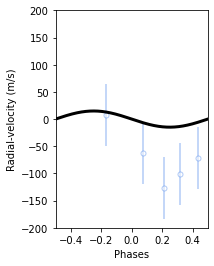

In [17]:
# Define times on which we'll evaluate the model to plot:
min_time, max_time = np.min(dataset.times_rv['MIKE'])-30,\
                 np.max(dataset.times_rv['MIKE'])+30
model_rv_times = np.linspace(min_time,max_time,1000)

# Evaluate RV model --- use all the posterior samples, also extract model components:
rv_model, components = results.rv.evaluate('MIKE', t = model_rv_times, all_samples = True, \
                                           return_components = True)
# Substract FEROS systemic RV from rv_model:
rv_model -= components['mu']

# Define second panel in the plot:
ax2 = plt.subplot(gs[1])

# Iterate through the instruments, evaluate a model at those times, remove the full model - planet component, so only the RV
# from the planet under study remain:
instruments = ['MIKE',]
colors = ['cornflowerblue','orangered']
for i in range(len(instruments)):
    instrument = instruments[i]
    # Evaluate jitter level --- will be added in quadrature to data errors:
    jitter = np.median(results.posteriors['posterior_samples']['sigma_w_'+instrument])
    # Get phases:
    phases = juliet.get_phases(dataset.times_rv[instrument], P, t0)
    # Plot data with the full model *minus* planet 1 substracted, so we see the Keplerian of planet
    # 1 imprinted on the data. For this, evaluate model in the data-times first:
    c_model, c_components = results.rv.evaluate(instrument, t = dataset.times_rv[instrument], \
                                                all_samples=True, return_components = True)
    # Now plot RV data with (best model - planet component) substracted:
    ax2.errorbar(phases, dataset.data_rv[instrument]- (c_model - c_components['p1']),\
                 yerr = np.sqrt(dataset.errors_rv[instrument]**2+jitter**2),fmt='o',\
                 mec=colors[i], ecolor=colors[i], mfc = 'white', label=None,\
                 alpha = 0.5, zorder=5)

# Now plot the model for planet 1. First get phases of the model:
phases = juliet.get_phases(model_rv_times, P, t0)
# Plot phased model:
idx = np.argsort(phases)
plt.plot(phases[idx], components['p1'][idx], color='black', lw = 3, zorder=6)
# Define limits, labels:
ax2.set_xlim([-0.5,0.5])
ax2.set_ylim([-200,200])
ax2.set_xlabel('Phases')
ax2.set_ylabel('Radial-velocity (m/s)')

In [5]:
# Scratch space

.02 / (np.sqrt(1.672)*np.sqrt(2))

0.010936965981495177

In [6]:
log2pi = np.log(2.*np.pi)
taus = np.array([211302.63980060548, 211668.73506167933, 212121.3595242822,
 278341.5472256466, 277989.9022129493, 278293.25345918833])
residuals = np.array([0.0433923105186822, 0.04594177998965998, 0.047107229608953194,
 0.0471079448646905, 0.049205313105046944, 0.04462231196826716])
variances = np.array([4.732548542430157e-06, 4.724363282601015e-06, 4.714282438329964e-06 ,
 3.5927083468761403e-06, 3.5972529650878024e-06, 3.5933318094132306e-06])

In [7]:
-0.5*(len(residuals)*log2pi+np.sum(-np.log(taus)+taus*(residuals**2)))

-1548.4157968167467